# Brief Tutorial on LSTM with Bitcoin price data

This is a sample application of LSTM model on a time-series bitcoin price data using <a href='https://pytorch.org/'>pytorch</a> library. The notebook is written in python3 and the anaconda installation will pretty much include everything you need, except pytorch itself. For a brief background on LSTM check out <a href='https://wiki.pathmind.com/lstm'>aiwiki page</a>, and an excellent <a href='https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21'>post by Michael Phi</a>.

### Obtaining data

There are many sources where you can download historical bitcoin price data. A minor issue is that there are multiple exchanges spanning variable time intervals. For simplicity, here we will utilize the API of blockchain.info to retrieve recent average USD market price across the current major exchanges. More comprehensive historical data (for individual exchanges and for smaller time bins) can be accessed through bitcoincharts.com [http://api.bitcoincharts.com/v1/csv/]. 

The daily average USD price data from the past year can be accessed as:
https://api.blockchain.info/charts/market-price?format=json&timespan=1year

here note the timespan is set to "1year", you can try "30days", "180days", or "3years" etc. If you put this link into your browser you'll see the JSON text, which we download and parse into a python object as:

In [1]:
import json, urllib.request

url      = 'https://api.blockchain.info/charts/market-price?format=json&timespan=1year'
jsondata = urllib.request.urlopen(url).read().decode()
pydata   = json.loads(jsondata)

Here pydata is a dictionary (try "pydata.keys()") and the stuff we want - price as a function of time - is listed in the key "values". It is a list with 366 items, each a dictionary, and for example the last item would be the average price from today:

In [2]:
pydata['values'][-1]

{'x': 1618358400, 'y': 63554.44}

Here the value assigned to the key 'x' is the time in <a href='https://en.wikipedia.org/wiki/Unix_time'>unix epoch</a>, but we don't need them in our analysis since the data are evenly spaced in time. The stuff we want is average USD price for each day, which we extract into numpy array (will be easier to deal with later):

In [3]:
import numpy as np

p = np.array([item['y'] for item in pydata['values']])

Plotting the price on log-scale we get:

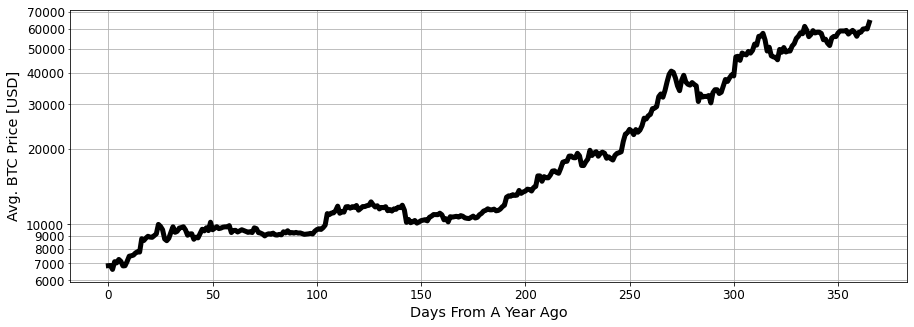

In [5]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import ScalarFormatter

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

def mk_loglin_plt():
    fig, ax = plt.subplots()
    ax.grid(which='both')
    ax.set(ylabel='Avg. BTC Price [USD]', xlabel='Days From A Year Ago', yscale='log')
    ax.plot(p, lw=5, c='black')
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_minor_formatter(ScalarFormatter())
        axis.set_major_formatter(ScalarFormatter())
    return fig, ax

mk_loglin_plt()
plt.show()

### Traning LSTM model

The following implementation is loosely based on <a href='https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/'>this</a> blog post, but several minor bugs have been fixed here. We start by splitting our data into two sets, one for training and one for testing. For simplicity we will just take the last month data as a test (30 elements), and put the rest into the training set (336 elements):

In [6]:
isplit = 30 # days
dtrain, dtest = p[:-isplit], p[-isplit:]

Since the price a year ago was so much smaller than today's we rescale our training set to range (-1, 1) using the MinMaxScaler from sklearn. Once rescaled we convert them into float tensors:

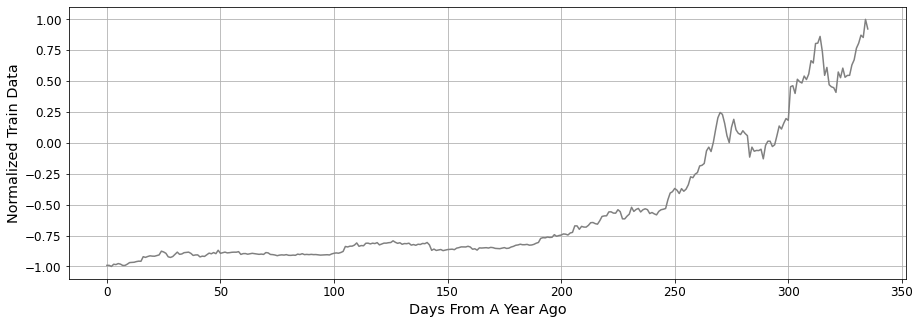

In [7]:
import torch
from sklearn.preprocessing import MinMaxScaler

# rescale
scaler = MinMaxScaler(feature_range=(-1, 1))
norm_dtrain = scaler.fit_transform(dtrain.reshape(-1, 1))

# plot norm_dtrain
def mk_linlin_plt(x, y, xlbl, ylbl, grid='yes', c='gray'):
    fig, ax = plt.subplots()
    ax.plot(x, y, color=c)
    ax.set(xlabel=xlbl, ylabel=ylbl)
    if grid == 'yes': ax.grid()
    return fig, ax

mk_linlin_plt(np.arange(len(norm_dtrain)), norm_dtrain, 'Days From A Year Ago', 'Normalized Train Data')
plt.show()

# convert into tensors
norm_dtrain = torch.FloatTensor(norm_dtrain).view(-1)

We now transform our normalized training set into sequences and labels through a custom train window interval - wtrain. The function below builds these as tuples by sampling a sequence of wtrain elements and assigning them to a label of element[wtrain+1]. The training interval is a free parameter (?) but for best results one need to apply some domain knowledge (more on this in the analysis section below). 

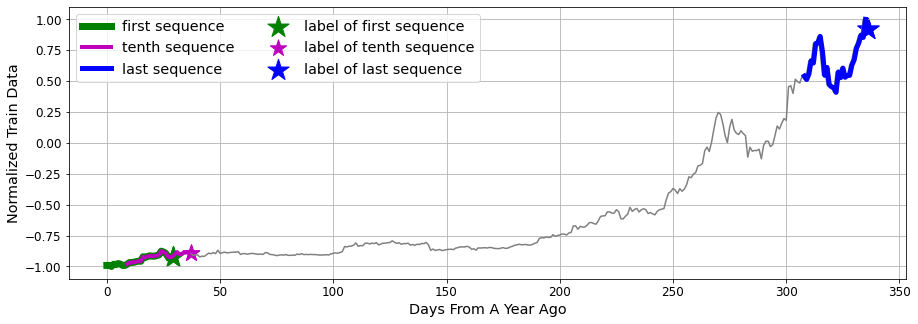

In [8]:
# tunable training window in [days]
tw = 28

def io_seq(d, tw):
    """ creates sequences and corresponding labels for the input data d in a train window of tw"""
    io_seq = []
    for i in range(len(d) - tw):
        seqtrain = d[i:i+tw]
        lbltrain = d[i+tw:i+tw+1]
        io_seq.append((seqtrain, lbltrain))
    return io_seq

io_seqtrain = io_seq(norm_dtrain, tw)

# first, tenth, and last sequences and their labels are highlighted
fig, ax = mk_linlin_plt(np.arange(len(norm_dtrain)), norm_dtrain, 'Days From A Year Ago', 'Normalized Train Data')
seq1st, lbl1st = io_seqtrain[0][0],  io_seqtrain[0][1]  # first
seqtth, lbltth = io_seqtrain[9][0],  io_seqtrain[9][1]  # tenth
seqlst, lbllst = io_seqtrain[-1][0], io_seqtrain[-1][1] # last
ax.plot(                                         seq1st, c='g', lw=7, label='first sequence')
ax.plot(np.arange(len(seqtth))+9,                seqtth, c='m', lw=4, label='tenth sequence')
ax.plot(np.arange(len(dtrain)-tw,len(dtrain),1), seqlst, c='b', lw=5, label='last sequence')
ax.scatter([tw+1,        tw+1],        [lbl1st, lbl1st], marker='*', c='g', s=500, label='label of first sequence')
ax.scatter([tw+9,        tw+9],        [lbltth, lbltth], marker='*', c='m', s=300, label='label of tenth sequence')
ax.scatter([len(dtrain), len(dtrain)], [lbllst, lbllst], marker='*', c='b', s=500, label='label of last sequence')
plt.legend(ncol=2)
plt.show()

The choices for loss function and optimizer will be elaborated later, but for now we stick with a version of stochastic gradient descent ("Adam" optimizer) and the cross entropy loss. Then we build the blueprint for the LSTM model as a python class inheriting from <a href='https://pytorch.org/docs/stable/generated/torch.nn.Module.html'>torch.nn.Module</a>, where we set the initial state by calling the parent class and set the LSTM and linear layers though 3 parameters. The input and output sizes (isz, osz) are set to 1 since we have a single price per day, and for a relatively quick computation we stick with a single layer of 100 neurons (hidden).

The predictions are computed through the forward method in this class by first passing the input sequence through LSTM layer, and then by passing its output through linear layer.

In [9]:
# cross entropy loss
floss = torch.nn.MSELoss()


class LSTM(torch.nn.Module):
    """LSTM model"""
    def __init__(self, isz=1, hidden=100, osz=1):
        super().__init__()
        self.hidden_layer_size = hidden

        self.lstm = torch.nn.LSTM(isz, hidden)
        self.linear = torch.nn.Linear(hidden, osz)
        
        # previsou hidden and cell state
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size), torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, iseq):
        # output, current time step hidden and cell state
        lstm_out, self.hidden_cell = self.lstm(iseq.view(len(iseq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(iseq), -1))
        # last element is the actual predicted value for the sequence
        return predictions[-1]

    
model = LSTM()
# Adam optimizer; learning rate is by default 0.001
optimizer = torch.optim.Adam(model.parameters())

Now we train our model through a custom number of epochs in the following loop by going through each sequence-label combination in io_seqtrain. With the current simple setup with single layer of 100 neurons and 100 epochs it takes about ~4 min on my laptop (using 2 threads on 1 core). The actual loss values for every 10th epoch are printed:

In [10]:
# train for 100 epochs
epochs = 100

l = []
print('epoch        loss')
for epoch in range(epochs):
    for seq, lbl in io_seqtrain:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = floss(y_pred, lbl)
        single_loss.backward()
        optimizer.step()

    # collect loss and print for every 10th epoch
    l.append(single_loss.item())
    if epoch % 10 == 0: print(f'{epoch:3}     {single_loss.item():10.8E}')

epoch        loss
  0     1.71021789E-01
 10     8.91289790E-04
 20     1.81530649E-03
 30     1.02915661E-03
 40     3.17934901E-04
 50     4.15115571E-03
 60     2.42146096E-04
 70     7.85216410E-03
 80     5.64632425E-03
 90     1.05154212E-03


visualizing the loss for each epoch we get:

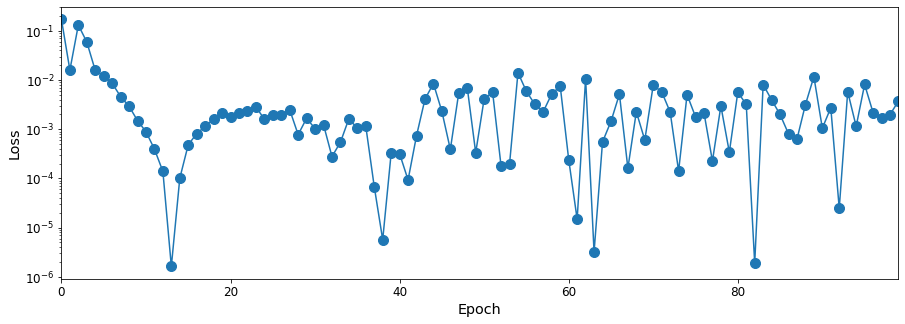

In [11]:
fig, ax = plt.subplots()
ax.plot(l)
ax.scatter(np.arange(len(l)), l, s=100)
ax.set(ylabel='Loss', xlabel='Epoch', yscale='log', xlim=[0, len(l)-1])
plt.show()

### Prediction

Once trained we use our model to make predictions through the following for loop. First we extract the last piece of our normalized train data in the same shape as testdata (itest), and then for each day of the prediction time range we use its subset in the same shape as our train window (itest[-tw:]) as a sequence to make predictions in normalized format. Here note that predictions are appended to the itest list, and that past ones are used to make future date predictions. Finally we apply inverse transform to obtain predicted USD prices using our scaler function.

In [12]:
itest = norm_dtrain[-isplit:].tolist()

for day in range(isplit):
    seq = torch.FloatTensor(itest[-tw:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        itest.append(model(seq).item())

# the last isplit elements are normalized predictions
norm_pred = itest[-isplit:]
# convert to avg. USD prices
LSTMpred = scaler.inverse_transform(np.array(norm_pred).reshape(-1, 1))

The following script plots the results in red; a zoomed in comparison in lin-space is shown as an inset:

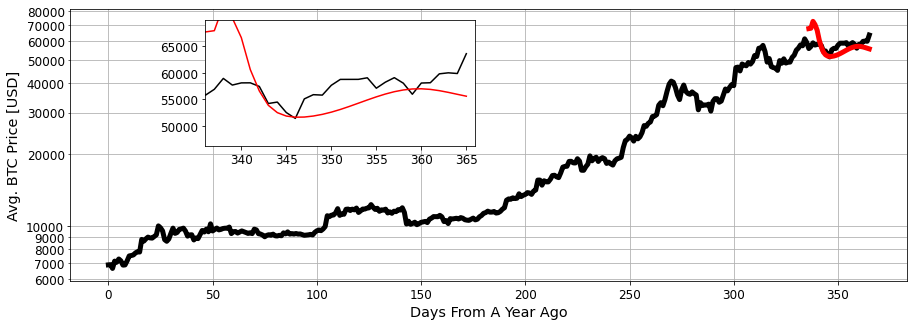

In [13]:
fig, ax = mk_loglin_plt()
x = np.arange(len(p)-isplit, len(p), 1)
ax.plot(x, LSTMpred, c='red', lw=5)

left, bottom, width, height = [0.25, 0.50, 0.25, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlim(len(p)-isplit, len(p))
ax2.set_ylim(min(p[-isplit:])*0.9, max(p[-isplit:])*1.1)
ax2.plot(   p,        c='black')
ax2.plot(x, LSTMpred, c='red')

plt.show()

It is not too shabby for a quick test, but you'll notice that the results sensisitively depend on many of the seemingly arbitrary choices we made along the way. How the results depend on the training window size, epoch limit, number of neurons and their layers? What about the choice of the loss function and optimizer? The data could have been split differently (into train/test) and obviously we could have used smaller or larger data. We will dive into some of these in the next section.

### Analysis

coming soon...